<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Angry--Arandi/Angry_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive to acess data 

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
pwd

'/content/drive/My Drive/ECS171/emotionDataSet'

In [45]:
%cd '/content/drive/MyDrive/ECS171/emotionDataSet'

/content/drive/MyDrive/ECS171/emotionDataSet


In [46]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [47]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [48]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [49]:
IMG_SIZE= (48, 48)

In [11]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [09:50<00:00, 98.41s/it]


28174 images loaded from Training/Training/ directory.


In [50]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [13]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [01:54<00:00, 19.16s/it]


7122 images loaded from Testing/Testing/ directory.


In [51]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})

In [52]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  

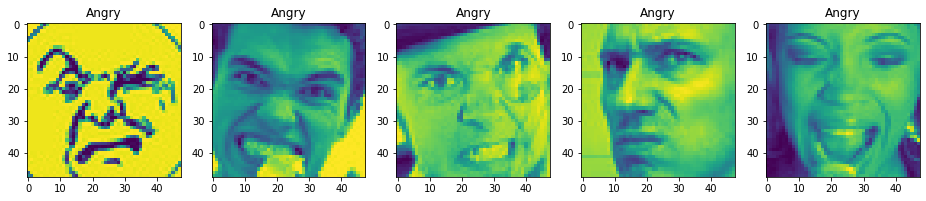

In [53]:
Angry_DIR = TRAIN_DIR + "/Angry/"
Angry_imgs = [Angry_DIR + path for path in os.listdir(Angry_DIR)]

fig, axes = plt.subplots(1,5, figsize=(16,16))
for ax in axes.reshape(-1):
    img_path = np.random.choice(Angry_imgs)
    img = Image.open(img_path)
    img.thumbnail((300,300))
    ax.imshow(img), ax.set_title("Angry")
plt.show()

In [54]:
img = cv2.imread('Training/Training/Angry/Angry-1.jpg')[1].mean()
img

155.66666666666666

In [55]:
with Image.open('Training/Training/Angry/Angry-1.jpg') as rgb_image:
    image_color = rgb_image.getpixel((45,45))
    print(image_color)

184


In [56]:
image_list = []

path = TRAIN_DIR + '/Angry'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 4056


In [57]:
img_data

,filename,size
0,Angry-3832.jpg,1621
1,Angry-2789.jpg,1558
2,Angry-3228.jpg,1732
3,Angry-3538.jpg,1413
4,Angry-2942.jpg,1558
...,...,...
4051,Angry-1396.jpg,1510
4052,Angry-24.jpg,1341
4053,Angry-1690 (1).jpg,1552
4054,Angry-1057.jpg,1589


In [58]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
3278,Angry-1126.jpg,1476,1,8
3027,Angry-2099.jpg,1295,1,4


In [59]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

In [60]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [61]:
import cv2  
from skimage.metrics import structural_similarity

delete = []
similar = []

for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    candidates = []

    for j in range(len(temp) - 1):
      for k in range(j+1, len(temp)):
        filenameA = temp['filename'][j]
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        if (score == 1):
          delete.append([filenameA, filenameB])
        elif (score > 0.5):
          similar.append([filenameA, filenameB])
          print("score: " + str(score))

score: 0.8265641046829441
score: 0.8265641046829441
score: 0.8265641046829441
score: 0.9970983126941559
score: 0.8757148997606973
score: 0.8410041402330637
score: 0.5638229936918498
score: 0.8760352990644359
score: 0.7327278660858202
score: 0.7917911448636352
score: 0.9922844453030049
score: 0.9922844453030049
score: 0.7048035211453414


In [62]:
print(str(len(delete)) + " same image pairs found")
print(str(len(similar)) + " similar image pairs found")

299 same image pairs found
13 similar image pairs found


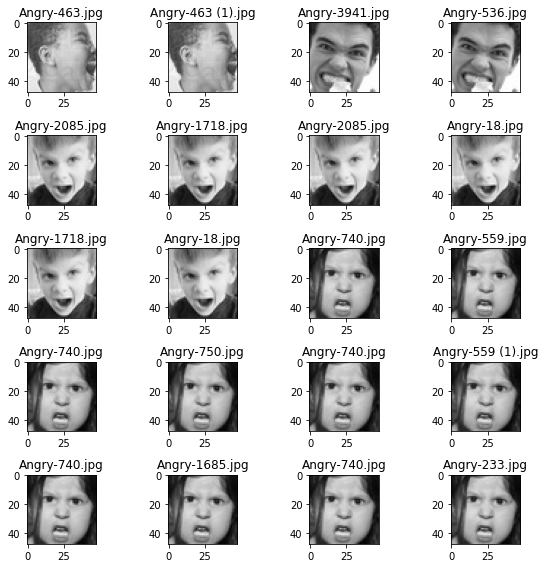

In [63]:
pic_size = 48

plt.figure(0, figsize=(8,8))
cpt = 0

for i in range(len(delete[:10])):
  for filename in delete[i]:
    cpt += 1
    ax = plt.subplot(5,4,cpt)
    ax.set_title(filename)

    img = cv2.imread(path+"/"+ filename)
    plt.imshow(img,cmap="gray")
    pass

plt.tight_layout()
plt.show()

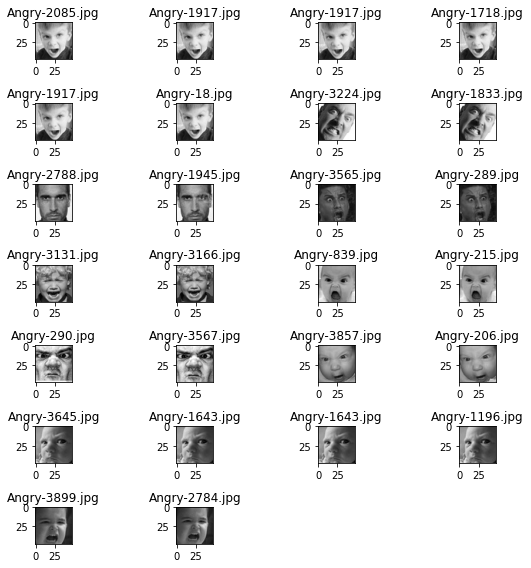

In [64]:
pic_size = 48

plt.figure(0, figsize=(8,8))
cpt = 0

for i in range(len(similar)):
  for filename in similar[i]:
    cpt += 1
    ax = plt.subplot(7,4,cpt)
    ax.set_title(filename)

    img = cv2.imread(path+"/"+ filename)
    plt.imshow(img,cmap="gray")
    pass

plt.tight_layout()
plt.show()

In [65]:
path = 'Training/Training/Angry'

In [66]:
widths = dict()
heights = dict()

for img in os.listdir(path):
  img = cv2.imread(path + '/' + img)
  width, height, _ = img.shape
  widths[width] = widths.get(width,0)+1
  heights[height] = widths.get(height,0)+1

In [67]:
print(widths)
print(heights)

{48: 4056}
{48: 4057}


,0,1,Name
0,4056,976,Angry
1,4125,1033,Fear
2,7086,1774,Happy
3,4861,1267,Neutral
4,4869,1244,Sad
5,3177,828,Suprise


In [69]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [01:12<00:00, 12.11s/it]


28174 images loaded from Training/Training/ directory.


In [70]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:17<00:00,  2.91s/it]

7122 images loaded from Testing/Testing/ directory.


In [71]:
import pandas as pd

_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})

In [72]:
data

,train,test,emotion
0,4056,976,Angry
1,4125,1033,Fear
2,7086,1774,Happy
3,4861,1267,Neutral
4,4869,1244,Sad
5,3177,828,Suprise


In [20]:
data_after = df.rename(columns={0: "Training Data", 1: "Testing Data","Name" : "Emotions"})
data_after = data_after.set_index("Emotions")
data_after

,Training Data,Testing Data
Emotions,,
Angry,4056,976
Fear,4125,1033
Happy,7086,1774
Neutral,4861,1267
Sad,4869,1244
Suprise,3177,828


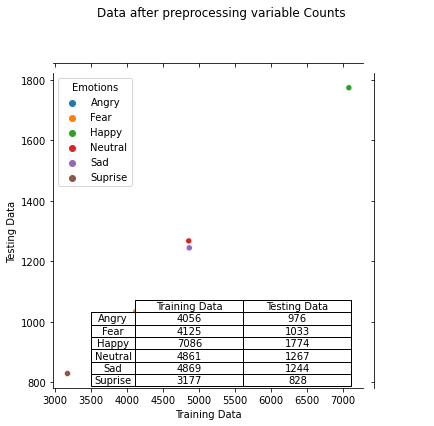

In [74]:

#INVALID NOT THE ACTUAL TABLE PLEASE OMIT
#preprocessing table 

sns.jointplot(data=data_after, x="Training Data", y="Testing Data",hue = "Emotions")

plt.suptitle('Data after preprocessing variable Counts')
plt.subplots_adjust(left=0.3, bottom=0.4)
table = plt.table(cellText=data_after.values,
          rowLabels=data_after.index,
          colLabels=data_after.columns,
          cellLoc = 'center', rowLoc = 'center',
          transform=plt.gcf().transFigure,
          bbox = ([0.3, 0.1, 0.5, 0.2]))
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.savefig('table.pdf',bbox_inches='tight')
#########WRONG############################################

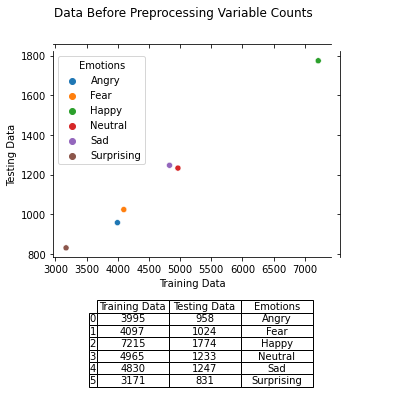

In [73]:
import seaborn as sns
data_b = pd.DataFrame({'Training Data':[3995, 4097,7215,4965,4830,3171], 'Testing Data':[958,1024,1774,1233,1247,831], 'Emotions' :['Angry', 'Fear','Happy',"Neutral", 'Sad','Surprising']})
sns.jointplot(data=data_b, x="Training Data", y="Testing Data",hue = "Emotions")

plt.suptitle('Data Before Preprocessing Variable Counts')
plt.subplots_adjust(left=0.2, bottom=0.4)
table = plt.table(cellText=data_b.values,
          rowLabels=data_b.index,
          colLabels=data_b.columns,
          cellLoc = 'center', rowLoc = 'center',
          transform=plt.gcf().transFigure,
          bbox = ([0.3, 0.1, 0.5, 0.2]))
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.savefig('table_.pdf',bbox_inches='tight')